In [1]:
import numpy as np
import torch
import sys
import os
import json 
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics._ranking import _binary_clf_curve, precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, plot_roc_curve
from matplotlib import pyplot as plt

In [8]:
# #!/usr/bin/env python3
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from sklearn import metrics as skmet
import torch
from tqdm import tqdm

def make_batches(x_mat,y_mat,batch_size,shuffle=True):
	if shuffle:
		shuffled_order=np.random.permutation(x_mat.shape[0])
		x_mat=x_mat[shuffled_order,:]
		y_mat=y_mat[shuffled_order,:]
	train_dataset=[]
	start=0
	while start + batch_size <= x_mat.shape[0]:
		end=min(start+batch_size,x_mat.shape[0])
		train_dataset.append((x_mat[start:end,:],
							y_mat[start:end,:]))
		start+=batch_size
	return train_dataset

def my_sim(y_batch, anchor_y, factors):
	y_batch[np.where(y_batch == 0)] = -1
	sims = np.sum((y_batch * (anchor_y*factors)) == 1, axis=1) / np.sum(np.logical_or((y_batch * (anchor_y*factors)) == 1, (y_batch * (anchor_y*factors))==-1), axis=1)
	sims[np.where(np.isnan(sims))] = 0
	return sims



def select_triplets(embeddings,y_batch,max_negatives_per_pos,max_trips_per_anchor,factors,debug=False):
	triplets=[]
	for i in range(0,embeddings.shape[0]):
		anchor=embeddings[i,:]
		anchor_y=y_batch[i,:]
		# get similarity scores
		sim_scores=np.nansum(y_batch * (anchor_y*factors),axis=1)
		# sim_scores = my_sim(y_batch, anchor_y, factors)
		# get embedding distances
		dists=np.sqrt(np.sum((embeddings-anchor)**2,axis=1))
		distance_order=np.argsort(dists)
		sim_distance_order=sim_scores[distance_order]
		num_anchor_triplets=0
		positive_idcs=np.nonzero(sim_distance_order>0)[0]
		num_fine=0
		num_coarse=0
		# mine positives first, starting with the back
		for j,pos_idx in enumerate(np.flip(positive_idcs)):
			# its the anchor
			if distance_order[pos_idx]==i:
				continue
			pos_sim=sim_distance_order[pos_idx]
			# generate fine triplets
			positive_misorderings=np.logical_and(sim_distance_order[:pos_idx]<pos_sim,sim_distance_order[:pos_idx]>0)
			for neg_idx in np.nonzero(positive_misorderings)[0]:
				triplets.append((i,
								distance_order[pos_idx],
								distance_order[neg_idx]))
				num_anchor_triplets+=1
				num_fine+=1
			# generate coarse triplets
			zero_idcs=np.nonzero(sim_distance_order[:pos_idx]==0)[0]
			if len(zero_idcs)==0:
				continue
			num_negatives=np.minimum(max_negatives_per_pos,zero_idcs.shape[0])
			# for _ in range(0,num_negatives):
			# 	# choose a negative randomly, because there are a lot of negatives
			# 	# and since as we go down the positive_idcs, the previous zero_idcs
			# 	# is included, so we don't want to keep choosing the same negatives
			# 	k=np.random.randint(0,len(zero_idcs))
			# 	neg_idx=zero_idcs[k]
			# 	triplets.append((i,
			# 					distance_order[pos_idx],
			# 					distance_order[neg_idx]))
			# 	num_anchor_triplets+=1
			# 	num_coarse+=1
			# 	if debug:
			# 		print((i,distance_order[pos_idx],distance_order[neg_idx]))
			
			if num_anchor_triplets>=max_trips_per_anchor:
				break
	return triplets


def get_triplets(embeddings,y_batch,max_negatives_per_pos,max_trips_per_anchor,factors,debug=False):
	trips_list=select_triplets(embeddings.detach().numpy(),y_batch,max_negatives_per_pos,max_trips_per_anchor,factors,debug)
	if len(trips_list)==0:
		return None
	anchors=[]
	positives=[]
	negatives=[]
	for (a,p,n) in trips_list:
		anchors.append(embeddings[a,:].reshape(1,embeddings.shape[1]))
		positives.append(embeddings[p,:].reshape(1,embeddings.shape[1]))
		negatives.append(embeddings[n,:].reshape(1,embeddings.shape[1]))
	anchors=torch.cat(anchors,0)
	positives=torch.cat(positives,0)
	negatives=torch.cat(negatives,0)
	return anchors,positives,negatives


def scheduled_value(epoch,list_of_vals):
	sched_val=None
	for (st,val) in list_of_vals:
		if st<=epoch:
			sched_val=val
	return sched_val


def precision_at_k(y_tst,probs_pred,k):
	assert(k>0 and int(k)==k)
	assert(y_tst.shape[0]==probs_pred.shape[0])
	
	##MMD
	probs_pred = 1 - probs_pred
	top_k=np.argsort(probs_pred,axis=1)[:,:k]
	##END
	#top_k=np.argsort(probs_pred,axis=1)[:,-k:]
	total=0
	for s_idx in range(0,y_tst.shape[0]):
		best_labels=top_k[s_idx,:]
		total+=np.nansum(y_tst[s_idx,best_labels])
	p_at_k=total/(y_tst.shape[0])
	p_at_k=p_at_k/k
	return p_at_k


def compute_mlr_metrics(nbrs,num_neighbours,y_trn,emb_tst,y_tst,prefix):
	nbr_distances, nbr_indices = nbrs.kneighbors(emb_tst)
	y_nbr=y_trn[nbr_indices,:]
	assert(y_nbr.shape==(emb_tst.shape[0],num_neighbours,y_tst.shape[1]))
	y_pred=np.nanmean(y_nbr,axis=1)
	metrics_df=pd.DataFrame(index=[0])
	metrics_df.loc[0,prefix+"p@1"]=precision_at_k(y_tst,y_pred,1)
	metrics_df.loc[0,prefix+"p@3"]=precision_at_k(y_tst,y_pred,3)
	metrics_df.loc[0,prefix+"p@5"]=precision_at_k(y_tst,y_pred,5)
	# metrics_df.loc[0,prefix+"ranking_loss"]=skmet.label_ranking_loss(y_tst,y_pred)
	# metrics_df.loc[0,prefix+"coverage_error"]=skmet.coverage_error(y_tst,y_pred)
	# metrics_df.loc[0,prefix+"avg_prec_score"]=skmet.label_ranking_average_precision_score(y_tst,y_pred)
	return metrics_df


def log_epoch_metrics(logfilename,epoch,epoch_loss,model,x_trn,y_trn,x_val,y_val,num_neighbours,do_print=True):
	# get embeddings
	
	emb_trn=model(torch.from_numpy(x_trn.reshape(6277, -1,3967).astype('float32'))).detach().numpy()
	emb_val=model(torch.from_numpy(x_val.reshape(784, -1,3967).astype('float32'))).detach().numpy()
	# create knn model
	nbrs = NearestNeighbors(n_neighbors=num_neighbours, algorithm='ball_tree').fit(emb_trn)
	# get training metrics
	trn_metrics=compute_mlr_metrics(nbrs,num_neighbours,y_trn,emb_trn,y_trn,"")
	trn_metrics.loc[0,"loss"]=epoch_loss
	trn_metrics.loc[0,"epoch"]=epoch
	trn_metrics.loc[0,"trn/val"]="trn"
	val_metrics=compute_mlr_metrics(nbrs,num_neighbours,y_trn,emb_val,y_val,"")
	val_metrics.loc[0,"loss"]=0
	val_metrics.loc[0,"epoch"]=epoch
	val_metrics.loc[0,"trn/val"]="val"
	# log metrics
	with open(logfilename,"a") as fi:
		trn_metrics.to_csv(fi,index=False)
		val_metrics.to_csv(fi,index=False)
	
	if do_print:
		print("Epoch : "+ str(epoch)+"\n")
		print(trn_metrics)
		print(val_metrics)

In [4]:
import torch
import torch.nn.functional as F

class SimpleNet(torch.nn.Module):
	def __init__(self,input_dim,output_dim,linear_widths):
		super(SimpleNet, self).__init__()
		self.linear_list=torch.nn.ModuleList([])
		assert(input_dim==linear_widths[0])
		assert(output_dim==linear_widths[-1])
		#simple network of successive linear layers
		for i in range(1,len(linear_widths)):
			inp_dim=linear_widths[i-1]
			out_dim=linear_widths[i]
			new_layer=torch.nn.Linear(inp_dim,out_dim)
			#initialize weights and bias    
			torch.nn.init.xavier_normal_(new_layer.weight, gain=1)
			new_layer.bias.data.fill_(0.01)
			self.linear_list.append(new_layer)


	#use relu or sigmoid?
	def forward(self,input_sample):
		x=input_sample
		for layer in self.linear_list:
			x = F.relu(layer(x))
		#normalize to restrict to unit hypersphere as in paper
		x = F.normalize(x, p=2, dim=1)#??
		return x

In [5]:
import numpy as np
import pandas as pd
import pickle
import os

## Paths to files

def load_dataset(dataset_name,debug=True):
	if dataset_name in ["mediamill","delicious","bibtex"]:
		return load_small_dataset(dataset_name,debug)
	else:
		return load_large_dataset(dataset_name,debug)


def load_large_dataset(dataset_name,debug=True):
	smalls=dataset_name.lower()
	train_path="../data/"+smalls+"/"+smalls+"_train.txt"
	test_path="../data/"+smalls+"/"+smalls+"_test.txt"
	trn_data=read_data_file(train_path,debug)
	tst_data=read_data_file(test_path,debug)
	return trn_data,tst_data


def load_small_dataset(dataset_name,debug=True):

	# check input
	dataset_names=["mediamill","delicious","bibtex"]
	if dataset_name not in dataset_names:
		print("Invalid input")
		return
	firstcap=dataset_name.capitalize()

	# path names
	data_path="../data/"  +  firstcap +"/"+ firstcap+"_data.txt"
	trsplit_path="../data/"  +  firstcap +"/"+ dataset_name+"_trSplit.txt"
	tstsplit_path="../data/"  +  firstcap +"/"+ dataset_name+"_tstSplit.txt"

	if debug:
		print("Loading datasets")
		print(data_path)
		print(trsplit_path)
		print(tstsplit_path)
	trsplits,tst_splits=read_split_files(trsplit_path,tstsplit_path,debug)
	return read_data_file(data_path,debug),trsplits,tst_splits

def read_data_file(data_path,debug):
	# Read header and lines (points)
	header=None
	lines=[]
	with open(data_path,"r") as daf:
		header=daf.readline()
		for l in daf:
			lines.append(l)
	num_points, num_features, num_labels =[int(x) for x in header.split()]
	if debug:
		print("## HEADER ##")
		print("#Point :",num_points,", #Features :",num_features,", #Labels :",num_labels)
	assert num_points==len(lines), "header num_points doesn't match with num_lines of file"

	# Parse lines to extract labels & features which are specified as 
	# [ { feats = [ (f1,v1),... ] } , labels = [ l1,...] },... ]

	import re
	all_points=[]
	for i,line in enumerate(lines):
		point={}
		
		#line begins with comma separated labels
		match=re.search(r"\A((\d*,)*(\d+))\s",line)
		labstring=""
		labels=[]
		if match :
			labstring=match.groups()[0]
			labels=[int(l) for l in labstring.split(",")]
		
		#followed by f1:v1 f2:v2 ...
		featstring=line.replace(labstring,"",1).strip()
		feats= featstring.split()
		feats =[f.split(":") for f in feats]
		feats= [(int(f[0]),f[1]) for f in feats]
		
		#check values are as expected
		#labels
		assert(len(labels)<=num_labels)
		if len(labels)>0:
			assert(max(labels)<num_labels)
			assert(min(labels)>=0)   
		#feats   
		feat_idcs= [f[0] for f in feats]
		assert(len(feats)<=num_features)
		assert(max(feat_idcs)<num_features)
		assert(min(feat_idcs)>=0)
		
		#fill list
		point["labels"]=labels    
		point["features"]=feats
		all_points.append(point)

	#cautionary
	assert(len(all_points)==num_points)

	# Read features into numpy array
	x_mat=np.zeros((num_points,num_features),dtype=float)
# 	x_mat[:]=np.nan
	for i,p in enumerate(all_points):
		for f_idx,f_val in p["features"]:
			x_mat[i][f_idx]=f_val

	# Read labels into numpy array
	y_mat=np.zeros((num_points,num_labels),dtype=int)
	for i,p in enumerate(all_points):
		for l in p["labels"]:
			y_mat[i][l]=1

	# Create dataframe
	full_dataset =pd.DataFrame({"features":[x_mat[i,:] for i in range(0,num_points)]
		,"labels_binary" : [y_mat[i,:] for i in range(0,num_points)]
		, "labels_list" : [all_points[i]["labels"] for i in range (0,num_points)]
		})

	return full_dataset

def read_split_files(trsplit_path,tstsplit_path,debug):
	# Read training split files into pandas dataframes
	trsplits=pd.read_csv(trsplit_path,header=None,delim_whitespace=True)
	tstsplits=pd.read_csv(tstsplit_path,header=None,delim_whitespace=True)
	#original files are 1 indexed 
	trsplits=trsplits-1
	tstplits=tstsplits-1
	num_splits=len(trsplits.columns)
	assert(len(tstsplits.columns)==num_splits)
	if debug:
		print("Number of splits :",num_splits)
	return trsplits,tstplits

def get_mulan_arrays(dataset_name):
	with open("../data/"+dataset_name+"/data_dict.p","rb") as fi:
		data_dict=pickle.load(fi)
		return data_dict["x_trn"],data_dict["y_trn"],data_dict["x_tst"],data_dict["y_tst"]


def get_small_dataset_split(dataset,trn_splits,tst_splits,split_num):
	assert(split_num<len(trn_splits))
	trn_data=dataset.iloc[trn_splits[split_num].to_numpy()]
	tst_data=dataset.iloc[tst_splits[split_num].to_numpy()]
	trn_data=trn_data.reset_index(drop=True)
	tst_data=tst_data.reset_index(drop=True)
	return trn_data,tst_data


def get_arrays(trn_data,tst_data):
	y_mat=np.vstack(trn_data["labels_binary"].to_numpy())
	x_mat=np.vstack(trn_data["features"].to_numpy())
	y_tst=np.vstack(tst_data["labels_binary"].to_numpy())
	x_tst=np.vstack(tst_data["features"].to_numpy())
	return x_mat,y_mat,x_tst,y_tst


def get_dataset_for_exp(DATASET,SPLIT=0,remove_unlabelled=True):
	# change dirs because paths are hardcoded in mydatasets
	if DATASET in ["delicious","mediamill","bibtex"]:
		full_dataset,trn_splits,tst_splits=load_small_dataset(DATASET)
		trn_data,tst_data=get_small_dataset_split(full_dataset,trn_splits,tst_splits,SPLIT)
		x_mat,y_mat,x_tst,y_tst=get_arrays(trn_data,tst_data)
	elif DATASET in ["eurlex"]:
		trn_data,tst_data=load_large_dataset(DATASET)
		x_mat,y_mat,x_tst,y_tst=get_arrays(trn_data,tst_data)
	elif DATASET in ["enron","yeast"]:
		x_mat,y_mat,x_tst,y_tst=get_mulan_arrays(DATASET)
	# remove nz samples
	nz_samples=np.sum(y_mat,axis=1)!=0
	x_mat_new=x_mat[nz_samples,:]
	y_mat_new=y_mat[nz_samples,:]
	print(x_mat_new.shape)
	nz_samples=np.sum(y_tst,axis=1)!=0
	x_tst_new=x_tst[nz_samples,:]
	y_tst_new=y_tst[nz_samples,:]
	print(x_tst_new.shape)
	return x_mat_new,y_mat_new,x_tst_new,y_tst_new

def get_validation_split(x_mat,y_mat,filename,valsplit=0.1):
	if os.path.exists(filename):
		with open(filename,"rb") as fi:
			data_dict=pickle.load(fi)
		trn_idcs=data_dict["trn"]
		val_idcs=data_dict["val"]
	else:
		num_val=int(x_mat.shape[0]*valsplit)
		perm=np.random.permutation(x_mat.shape[0])
		trn_idcs=perm[num_val:]
		val_idcs=perm[:num_val]
		with open(filename,"wb") as fi:
			data_dict={"trn":trn_idcs,"val":val_idcs}
			pickle.dump(data_dict,fi)	
	x_val=x_mat[val_idcs,:]
	y_val=y_mat[val_idcs,:]
	# replace
	x_trn=x_mat[trn_idcs,:]
	y_trn=y_mat[trn_idcs,:]
	return x_trn,y_trn,x_val,y_val

In [7]:
X = pd.read_csv('../data/gene_data.csv', header=None, index_col=0)
X

,1,2,3,4,5,6,7,8,9,10,...,3958,3959,3960,3961,3962,3963,3964,3965,3966,3967
0,,,,,,,,,,,,,,,,,,,,,
SRR1166318,0,0,1,0,0,4,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
ERR176810,0,0,1,0,2,3,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
ERR181956,0,0,1,0,1,3,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
SRR2100379,0,0,1,0,0,4,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
SRR924706,0,0,1,0,2,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR671746,0,0,1,0,0,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
SRR1146372,0,0,2,0,0,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ERR176477,0,0,1,0,1,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
Y = pd.read_csv('../data/AllLabels.csv', index_col='id')
Y = Y[Y.index.isin(X.index)]
Y

,amikacin,capreomycin,ciprofloxacin,ethambutol,ethionamide,isoniazid,kanamycin,moxifloxacin,ofloxacin,pyrazinamide,rifampicin,streptomycin
id,,,,,,,,,,,,
SRR3675211,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN
SRR3675215,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN
SRR3675217,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,0.0,1.0,NaN
SRR3675218,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,0.0,NaN
SRR3675224,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
SRR924705,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
SRR924706,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
SRR924707,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0


In [10]:
NoYs = X[np.logical_not(X.index.isin(Y.index))]
print('Xs with no Y found:', NoYs.shape[0])
X = X.drop(NoYs.index)

Xs with no Y found: 115


In [11]:
X = X.sort_index().reset_index().rename(columns={0: 'id'})
Y = Y.sort_index().reset_index()

In [12]:
X_mat = X.iloc[:, 1:].to_numpy()
Y_mat = Y.iloc[:, 1:].to_numpy()

In [13]:
val_test_count = int(X_mat.shape[0] * 0.1)
val_test_indcs = (np.random.permutation(X_mat.shape[0])[:2*val_test_count]).reshape((2, -1))

X_val = X_mat[val_test_indcs[0], :]
Y_val = Y_mat[val_test_indcs[0], :]

X_test = X_mat[val_test_indcs[1], :]
Y_test = Y_mat[val_test_indcs[1], :]

X_train = np.delete(X_mat, val_test_indcs.flatten(), axis=0)
Y_train = np.delete(Y_mat, val_test_indcs.flatten(), axis=0)
print(f'Train Count: {X_train.shape[0]}')
print(f'Validation Count: {X_val.shape[0]}')
print(f'Test Count: {X_test.shape[0]}')

shuffle_indcs = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffle_indcs, :]
Y_train = Y_train[shuffle_indcs, :]

Train Count: 6277
Validation Count: 784
Test Count: 784


In [14]:
def get_roc(x_train: np.ndarray, y_train: np.ndarray, x_eval: np.ndarray, y_eval: np.ndarray, model, n_neighbors=5):
    emb_train = model(torch.from_numpy(x_train.astype('float32'))).detach().numpy()
    emb_val = model(torch.from_numpy(x_eval.astype('float32'))).detach().numpy()
    KNN = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(emb_train)

    nbr_dists, nbr_indcs = KNN.kneighbors(emb_val)
    y_k_neghbors = y_train[nbr_indcs, :]
    y_pred = np.nanmean(y_k_neghbors, axis=1)
    y_pred[np.where(np.isnan(y_pred))] = 0.5
    #y_pred = np.round(y_pred)

    condition = np.where(np.logical_and(np.logical_not(np.isnan(y_eval)), np.logical_not(np.isnan(y_pred))))

    #### CALCULATE ROC

    #return np.sum(y_pred[condition] == y_eval[condition]) / y_eval[condition].shape[0]

In [15]:
def get_acc(x_train: np.ndarray, y_train: np.ndarray, x_eval: np.ndarray, y_eval: np.ndarray, model, n_neighbors=5):
    emb_train = model(torch.from_numpy(x_train.astype('float32'))).detach().numpy()
    emb_val = model(torch.from_numpy(x_eval.astype('float32'))).detach().numpy()
    KNN = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(emb_train)

    nbr_dists, nbr_indcs = KNN.kneighbors(emb_val)
    y_k_neghbors = y_train[nbr_indcs, :] #y_eval x 5 x 12
    y_pred = np.nanmean(y_k_neghbors, axis=1) #y_eval x 12
    y_pred = np.round(y_pred) #0.5 > --> 1

    condition = np.where(np.logical_and(np.logical_not(np.isnan(y_eval)), np.logical_not(np.isnan(y_pred))))

    return np.sum(y_pred[condition] == y_eval[condition]) / y_eval[condition].shape[0]

In [16]:
def ROC_Score(model, X_test, Y_test,X_train, Y_train, limited=False, model_name= "SVM"):

    num_of_drugs = 12


    if model_name == "SVM":
      from sklearn import svm
      clf = svm.SVC(kernel='linear') 
      for i in range(num_drugs):
        Y_train_i = Y_train[:, i]
        X_train_i = X_train[~np.isnan(Y_rain_i), :]
        Y_train_i = Y_train_i[~np.isnan(Y_rain_i)]
        
        

    
    emb_train = model(torch.from_numpy(X_train.astype('float32'))).detach().numpy()
    emb_test = model(torch.from_numpy(X_test.astype('float32'))).detach().numpy()
    KNN = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(emb_train)


    nbr_dists, nbr_indcs = KNN.kneighbors(emb_test)
    y_k_neghbors = Y_train[nbr_indcs, :] #y_eval x 5 x 12
    y_pred_keras_tmp = np.nanmean(y_k_neghbors, axis=1) #y_eval x 1
    
    condition_nan =  np.where(np.isnan(y_pred_keras_tmp))
    y_pred_keras_tmp[condition_nan] = 0.5
    
    condition = np.where(np.isnan(Y_test))
    Y_test[condition] = -1
    print(Y_test)

    
    for i in range(0, num_of_drugs):
        y_test_tmp = Y_test[:, i]
        y_pred_keras = y_pred_keras_tmp[:, i]
        i2 = 0
        while i2 < len(y_test_tmp):
            if y_test_tmp[i2] != 0 and y_test_tmp[i2] != 1:
                y_test_tmp = np.delete(y_test_tmp, i2)
                y_pred_keras = np.delete(y_pred_keras, i2)
            else:
                i2 = i2 + 1
    y_test_tmp = []
    y_pred_keras = []
    for i in range(0, num_of_drugs):
        y_test_tmp.extend(Y_test[:, i])
        y_pred_keras.extend(y_pred_keras_tmp[:, i])
    i = 0
    while i < len(y_test_tmp):
        if y_test_tmp[i] != 0 and y_test_tmp[i] != 1:
            y_test_tmp = np.delete(y_test_tmp, i)
            y_pred_keras = np.delete(y_pred_keras, i)
        else:
            i = i + 1
    fpr_keras, tpr_keras, _ = roc_curve(y_test_tmp, y_pred_keras)
    # print("___")
    # print(fpr_keras)
    # print("___")
    # print(tpr_keras)
    # print("___")
    auc_keras = auc(fpr_keras, tpr_keras)
    # print(auc_keras)
    return auc_keras

In [17]:
def ROC(model, X_test, y_test, X_train, Y_train, name, multi=False, limited=False, bccdc=False):
    
    num_of_drugs = 12
    
    
    emb_train = model(torch.from_numpy(X_train.astype('float32'))).detach().numpy()
    emb_test = model(torch.from_numpy(X_test.astype('float32'))).detach().numpy()
    KNN = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(emb_train)


    nbr_dists, nbr_indcs = KNN.kneighbors(emb_test)
    y_k_neghbors = Y_train[nbr_indcs, :] #y_eval x 5 x 12
    y_pred_keras_tmp = np.nanmean(y_k_neghbors, axis=1) #y_eval x 1
    
    condition_nan =  np.where(np.isnan(y_pred_keras_tmp))
    y_pred_keras_tmp[condition_nan] = 0.5
    
    condition = np.where(np.isnan(Y_test))
    Y_test[condition] = -1
    print(Y_test)    
    
    y_pred_keras = []
    y_test_tmp = []
    scores = []
    if limited:
        num_of_drugs = 7


    if bccdc:
        num_of_drugs = 5

        tmp_b = []
        for i in range(0, len(y_pred_keras_tmp)):
            tmp_b_b = [y_pred_keras_tmp[i][0], y_pred_keras_tmp[i][1], y_pred_keras_tmp[i][2], y_pred_keras_tmp[i][6],
                       y_pred_keras_tmp[i][8]]
            tmp_b.append(tmp_b_b)

        y_pred_keras_tmp = np.array(tmp_b)

    if multi == False:
        for i in range(0, len(y_pred_keras_tmp)):
            y_pred_keras.append(y_pred_keras_tmp[i][1])
            y_test_tmp.append(y_test[i][1])
        ROC_maker(y_test_tmp, y_pred_keras, name)
    else:
        for i in range(0, num_of_drugs):  # len(y_test[0])):
            y_test_tmp = y_test[:, i]
            y_pred_keras = y_pred_keras_tmp[:, i]
            # bug? cahnge i2 to i
            i2 = 0
            while i2 < len(y_test_tmp):
                if y_test_tmp[i2] != 0 and y_test_tmp[i2] != 1:
                    y_test_tmp = np.delete(y_test_tmp, i2)
                    y_pred_keras = np.delete(y_pred_keras, i2)
                else:
                    i2 = i2 + 1
            try:
                # print(len(y_test_tmp))
                # print(len(y_test_tmp[0]))
                # print(len(y_pred_keras))
                # print(len(y_pred_keras[0]))
                if i != 0:
                    if i < num_of_drugs - 1:
                        scores.append(ROC_maker(y_test_tmp, y_pred_keras, name + " _ " + str(i), False, False))
                    else:
                        scores.append(ROC_maker(y_test_tmp, y_pred_keras, name + " _ " + str(i), False, True))
                else:
                    scores.append(ROC_maker(y_test_tmp, y_pred_keras, name + " _ " + str(i), True, False))

            except():
                print("error on " + i + " " + y_test_tmp)
        y_test_tmp = []
        y_pred_keras = []
        for i in range(0, num_of_drugs):  # len(y_test[0])):
            y_test_tmp.extend(y_test[:, i])
            # print(y_test_tmp)
            y_pred_keras.extend(y_pred_keras_tmp[:, i])
        i = 0
        while i < len(y_test_tmp):
            if y_test_tmp[i] != 0 and y_test_tmp[i] != 1:
                y_test_tmp = np.delete(y_test_tmp, i)
                y_pred_keras = np.delete(y_pred_keras, i)
            else:
                i = i + 1
        ROC_maker(y_test_tmp, y_pred_keras, name + " _ All", True)
        # fpr_keras, tpr_keras, _ = roc_curve(y_test_tmp, y_pred_keras)
        # auc_keras = auc(fpr_keras, tpr_keras)
        # print(auc_keras)
        return scores

In [18]:
def specificity_recall_calculator(y_true, probas_pred, pos_label=None,
                                  sample_weight=None):
    fps, tps, thresholds = _binary_clf_curve(y_true, probas_pred,
                                             pos_label=pos_label,
                                             sample_weight=sample_weight)

    specificity = (fps[-1] - fps) / fps[-1]
    specificity[np.isnan(specificity)] = 0
    recall = tps / tps[-1]

    # stop when full recall attained
    # and reverse the outputs so recall is decreasing
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)
    return np.r_[specificity[sl], 1], np.r_[recall[sl], 0], thresholds[sl]

In [19]:
def SR_maker(y_test_tmp, y_pred_keras):
    specificity, recall, th = specificity_recall_calculator(y_test_tmp, y_pred_keras)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test_tmp, y_pred_keras)
    score = 0
    count = 0
    for i in range(0 ,len(recall)):
        if specificity[i] == 0.95:
            score += recall[i]
            count += count + 1

    if score != 0:
        return (score/count), auc(lr_recall, lr_precision)

    for i in range(0 ,len(recall)):
        if specificity[i] <= 0.952 and specificity[i] >= 0.945:
            score += recall[i]
            count += 1

    if score != 0:
        return (score/count), auc(lr_recall, lr_precision)

    for i in range(0, len(recall)):
        if specificity[i] <= 0.955 and specificity[i] >= 0.940:
            score += recall[i]
            count += 1
    if score != 0:
        return (score / count), auc(lr_recall, lr_precision)
    else:
        return 0, auc(lr_recall, lr_precision)

In [20]:
def PR(model, X_test, y_test, X_train, Y_train, bccdc=False):
    
    
    num_of_drugs = 12
    
    
    emb_train = model(torch.from_numpy(X_train.astype('float32'))).detach().numpy()
    emb_test = model(torch.from_numpy(X_test.astype('float32'))).detach().numpy()
    KNN = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(emb_train)


    nbr_dists, nbr_indcs = KNN.kneighbors(emb_test)
    y_k_neghbors = Y_train[nbr_indcs, :] #y_eval x 5 x 12
    y_pred_keras_tmp = np.nanmean(y_k_neghbors, axis=1) #y_eval x 1
    
    condition_nan =  np.where(np.isnan(y_pred_keras_tmp))
    y_pred_keras_tmp[condition_nan] = 0.5
    
    condition = np.where(np.isnan(Y_test))
    Y_test[condition] = -1

    y_pred_keras = []
    y_test_tmp = []
    scores_sr = []
    scores_pr = []

    if bccdc:
        num_of_drugs = 5

        tmp_b = []
        for i in range(0, len(y_pred_keras_tmp)):
            tmp_b_b = [y_pred_keras_tmp[i][0], y_pred_keras_tmp[i][1], y_pred_keras_tmp[i][2], y_pred_keras_tmp[i][6],
                       y_pred_keras_tmp[i][8]]
            tmp_b.append(tmp_b_b)

        y_pred_keras_tmp = np.array(tmp_b)



    for i in range(0, num_of_drugs):  # len(y_test[0])):
        y_test_tmp = y_test[:, i]
        y_pred_keras = y_pred_keras_tmp[:, i]
        i2 = 0
        while i2 < len(y_test_tmp):
            if y_test_tmp[i2] != 0 and y_test_tmp[i2] != 1:
                y_test_tmp = np.delete(y_test_tmp, i2)
                y_pred_keras = np.delete(y_pred_keras, i2)
            else:
                i2 = i2 + 1
        try:
            if i != 0:
                if i < num_of_drugs - 1:
                    sr, pr = SR_maker(y_test_tmp, y_pred_keras)
                    scores_sr.append(sr)
                    scores_pr.append(pr)
                else:
                    sr, pr = SR_maker(y_test_tmp, y_pred_keras)
                    scores_sr.append(sr)
                    scores_pr.append(pr)
            else:
                sr, pr = SR_maker(y_test_tmp, y_pred_keras)
                scores_sr.append(sr)
                scores_pr.append(pr)

        except():
            print("error on " + i + " " + y_test_tmp)
    # y_test_tmp = []
    # y_pred_keras = []
    # for i in range(0, num_of_drugs):  # len(y_test[0])):
    #     y_test_tmp.extend(y_test[:, i])
    #     # print(y_test_tmp)
    #     y_pred_keras.extend(y_pred_keras_tmp[:, i])
    # i = 0
    # while i < len(y_test_tmp):
    #     if y_test_tmp[i] != 0 and y_test_tmp[i] != 1:
    #         y_test_tmp = np.delete(y_test_tmp, i)
    #         y_pred_keras = np.delete(y_pred_keras, i)
    #     else:
    #         i = i + 1
    # SR_maker(y_test_tmp, y_pred_keras)
    return scores_sr, scores_pr

In [21]:
def ROC_maker(y_test_tmp, y_pred_keras, name, clear=True, save=True):
    # print(y_test_tmp)
    fpr_keras, tpr_keras, _ = roc_curve(y_test_tmp, y_pred_keras)
    auc_keras = auc(fpr_keras, tpr_keras)

    if clear:
        plt.clf()
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve _ ' + name)
    plt.legend(loc='best')
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    # if save:
    #     fig1.savefig('result/ROC_' + name + '.png', dpi=100)
    return auc_keras

In [22]:
import torch.nn as nn
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.drop1 = nn.Dropout(0.2)
        self.drop2 = nn.Dropout(0.3)
        self.drop3 = nn.Dropout(0.1)
        self.conv1 = nn.Conv1d(1, 8, kernel_size=3, padding = 'same')
        self.act = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=10, stride=4, padding=0)
        self.conv2 = nn.Conv1d(8, 4, kernel_size=6, padding = 'same')
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=1, padding=0)
        self.lstm1 = nn.LSTM(input_size=987, hidden_size=518, batch_first=True, num_layers=3, dropout=0.3)
        self.lstm2 = nn.LSTM(input_size=518, hidden_size=64, batch_first=True, num_layers=3, dropout=0.3)
        self.dense1 = nn.Linear(256, 64)
        self.dense2= nn.Linear(64, 518)

    def forward(self, x):
        x = self.drop1(x)
        x = self.act(self.conv1(x))
        x = self.pool1(x)
        x = self.act(self.conv2(x))
        x = self.pool2(x)
        x = self.lstm1(x)[0]
        x = self.drop1(x)
        x = self.lstm2(x)[0]
        x = self.drop2(x)
        x = x.reshape(x.size(0), -1)
        x = self.dense1(x)
        x = self.drop3(x)
        x = self.dense2(x)
        x = self.drop3(x)

        return x


In [27]:
# # model=SimpleNet(X_train.shape[1], 30, [X_train.shape[1], 1500, 30])
# model = NeuralNet()
# factors=np.zeros(Y_train.shape[1])+1.0
# log_every=1
# for epoch in range(200):
# 	# get scheduled values of hyper params
# 	tmargin=0
# 	batch_size=500
# 	lrate=0.001
# 	max_trips=100
# 	max_neg=3
# 	print("Epoch ",epoch,(tmargin,batch_size,lrate,max_trips,max_neg))
# 	# define loss and create optimizer
# 	triplet_loss = torch.nn.TripletMarginLoss(margin=tmargin, p=2)
# 	optimizer = torch.optim.Adam(model.parameters(),lr=lrate)
# 	# get batches
# 	mini_batches=make_batches(X_train, Y_train, batch_size)
# 	loss_values=[]
# 	for batch_num,batch in enumerate(tqdm(mini_batches, leave=False)):
# 		x_batch,y_batch=batch
# 		# generate embeddings
# 		# embeddings=model(torch.from_numpy(x_batch.astype('float32')))
# 		embeddings = model(torch.tensor(x_batch.reshape(500, -1,3967)).float())
# 		# generate triplets (online)
# 		trips=get_triplets(embeddings,y_batch,max_neg,max_trips,factors,debug=False)
# 		if trips is None:
# 			continue
# 		anch,pos,neg=trips
# 		# compute loss
# 		loss_batch=triplet_loss(anch,pos,neg)
# 		loss_values.append(loss_batch.detach().numpy())
# 		# backprop
# 		optimizer.zero_grad()
# 		loss_batch.backward(retain_graph=True)
# 		optimizer.step()
# 		print("Batch size :",anch.shape[0],", Loss value :",loss_batch.detach().numpy())
# 	loss_mean=np.mean(np.array(loss_values))
# 	# train_acc = get_acc(X_train, Y_train, X_train, Y_train, model, n_neighbors=5)
# 	# val_acc = get_acc(X_train, Y_train, X_val, Y_val, model, n_neighbors=5)
# 	print("\tTrain Loss for this epoch :",loss_mean)
# 	# print("\tTrain Accuracy for this epoch:", train_acc)
# 	# print("\tValidation Accuracy for this epoch:", val_acc)

	

	# if (epoch+1)%log_every==0:
	# 	log_epoch_metrics('t.txt',epoch,loss_mean,model,X_train,Y_train,X_val,Y_val,5)
	# # # evaluate model
	# # if (epoch+1)%checkpoint_every==0:
	# # 	torch.save(model,args["run_dir"]+"/model_"+str(epoch+1))

In [28]:
# get_acc(X_train, Y_train, X_test, Y_test, model, 1)

In [29]:
# ROC_Score(model, X_test, Y_test,X_train, Y_train, limited=False)
# score_for_each_drug = ROC(model, X_test, Y_test, X_train, Y_train, ("LRCN" + "BO_delete"), True)
# spec_recall, prec_recall = PR(model, X_test, Y_test, X_train, Y_train)
# print("recall at 95 spec: ", spec_recall)
# print("precision recall: ", prec_recall)


In [23]:
def ROC_ML(model, X_test, y_test, name, i, rf=False, xgb=False):
    if rf:
        ax = plt.gca()
        # print(len(X_test))
        # print(len(X_test[0]))
        # print(len(X_test[0][0]))
        # print(len(y_test))
        # print(len(y_test[0]))
        # print(len(y_test[0][0]))
        score = plot_roc_curve(model, X_test, y_test, ax=ax, alpha=0.8)
        plt.show()
        sr, pr = SR_maker(y_test, model.predict(X_test))
        return score.roc_auc, sr, pr
    else:
        if xgb:
            y_pred_keras_tmp = model.predict(X_test)
        else:
            y_pred_keras_tmp = model.decision_function(X_test)
        fpr_keras, tpr_keras, _ = roc_curve(y_test, y_pred_keras_tmp)
        auc_keras = auc(fpr_keras, tpr_keras)

        if i == 0 and name == "SVM":
            plt.clf()
        if i == 6 and name == "SVM":
            plt.clf()
        plt.figure(i)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label=name + str(i) + ' = {:.3f}'.format(auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve _ ' + name)
        plt.legend(loc='best')
        fig1 = plt.gcf()
        plt.show()
        plt.draw()
        # fig1.savefig('result/ROC_' + name + str(i) + '.png', dpi=100)

        sr, pr = SR_maker(y_test, model.predict(X_test))
        return auc_keras, sr, pr

In [24]:
import pickle

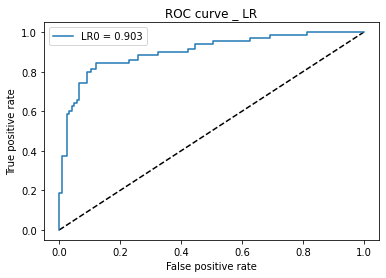

0.8549222797927462
(0.9026713124274099, 0, 0.8366753793486307)


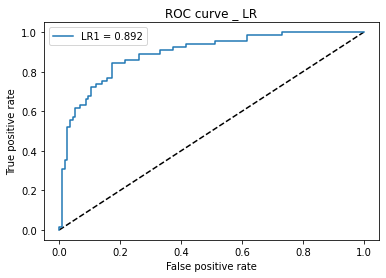

0.8222222222222222
(0.8915050167224081, 0, 0.7975407192388325)


<Figure size 432x288 with 0 Axes>

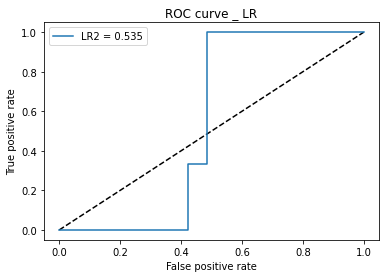

0.8611111111111112
(0.5353535353535354, 0, 0.041666666666666664)


<Figure size 432x288 with 0 Axes>

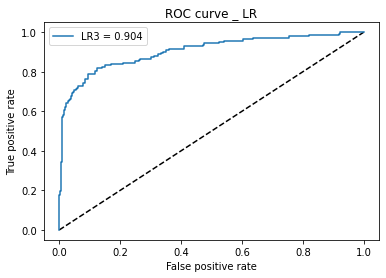

0.8956661316211878
(0.9043560606060607, 0, 0.7944376735033151)


<Figure size 432x288 with 0 Axes>

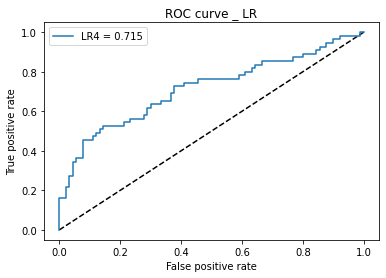

0.7241379310344828
(0.7147474747474747, 0, 0.689112317455463)


<Figure size 432x288 with 0 Axes>

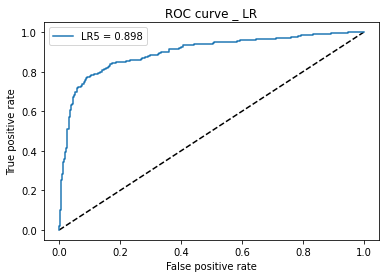

0.8412903225806452
(0.8984377154518628, 0, 0.8452362499190609)


<Figure size 432x288 with 0 Axes>

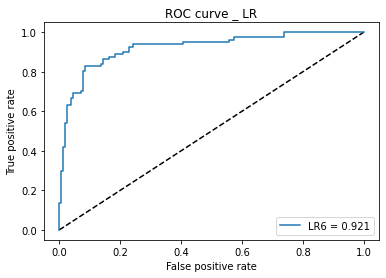

0.8626609442060086
(0.921133853151397, 0.691358024691358, 0.8437715254596513)


<Figure size 432x288 with 0 Axes>

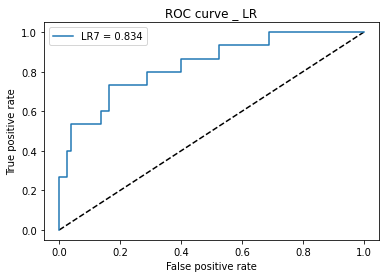

0.8842105263157894
(0.8341666666666666, 0, 0.6223684210526317)


<Figure size 432x288 with 0 Axes>

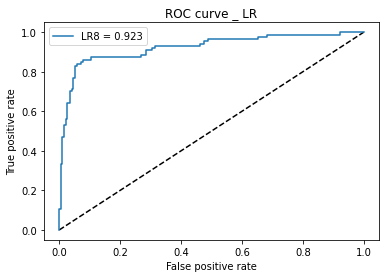

0.8785714285714286
(0.9227562384610803, 0, 0.839032269579496)


<Figure size 432x288 with 0 Axes>

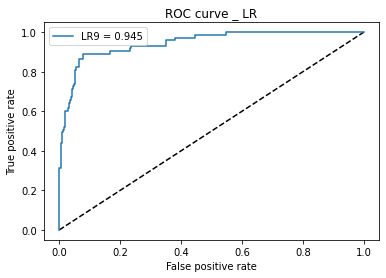

0.9130434782608695
(0.9454208667183596, 0.7397260273972602, 0.785464036716533)


<Figure size 432x288 with 0 Axes>

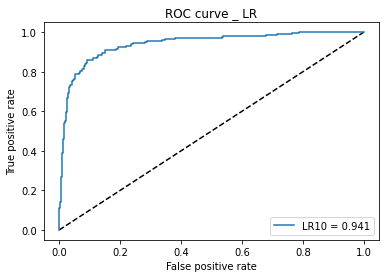

0.8860103626943006
(0.941040671587784, 0, 0.8726928940807226)


<Figure size 432x288 with 0 Axes>

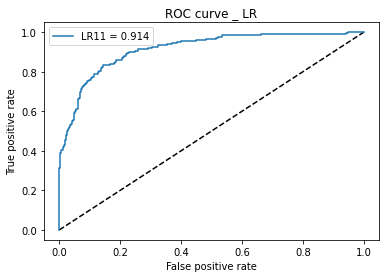

0.8473581213307241
(0.914094767309506, 0, 0.837796098526969)


TypeError: dump() missing required argument 'file' (pos 2)

<Figure size 432x288 with 0 Axes>

In [25]:
res_list = []
from sklearn.linear_model import LogisticRegression
condition = np.where(np.isnan(Y_test))
Y_test[condition] = -1
condition = np.where(np.isnan(Y_train))
Y_train[condition] = -1
for i in range(12):
  Y_test_i = Y_test[:, i]
  Y_train_i = Y_train[:,i]
  i2 = 0
  X_test_i = X_test
  while i2 < len(Y_test_i):
      if Y_test_i[i2] == -1 :
          Y_test_i = np.delete(Y_test_i, i2, axis = 0)
          X_test_i = np.delete(X_test_i, i2, axis=0)
      else:
          i2 = i2 + 1
  i2 = 0
  X_train_i = X_train
  while i2 < len(Y_train_i):
      if Y_train_i[i2] == -1 :
          Y_train_i = np.delete(Y_train_i, i2, axis = 0)
          X_train_i = np.delete(X_train_i, i2, axis = 0)
      else:
          i2 = i2 + 1
  
  lr_model_linear = LogisticRegression(C=0.1, penalty='l2', solver='newton-cg').fit(X_train_i, Y_train_i)
  score1 = ROC_ML(lr_model_linear, X_test_i, Y_test_i, "LR", i)
  accuracy = lr_model_linear.score(X_test_i, Y_test_i)
  res_list.append((accuracy, score1))
  print(accuracy)
  print(score1)
with open('Runs/LR.list', 'wb') as f:
    pickle.dump(res_list)

<Figure size 432x288 with 0 Axes>

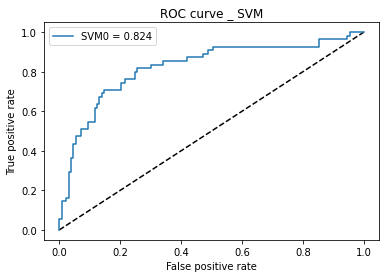

0.8097826086956522
(0.8236786469344607, 0, 0.7278692724344897)


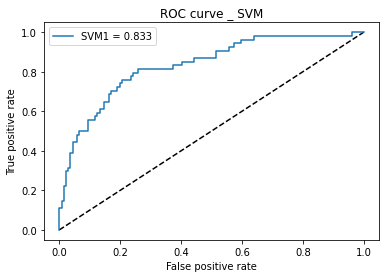

0.7894736842105263
(0.8330610021786492, 0, 0.6741910331384016)


<Figure size 432x288 with 0 Axes>

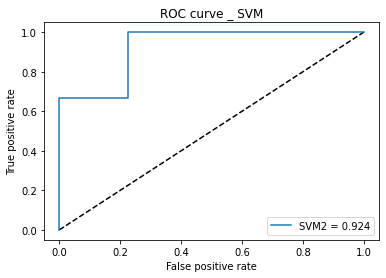

0.9574468085106383
(0.9242424242424242, 0, 0.6879432624113475)


<Figure size 432x288 with 0 Axes>

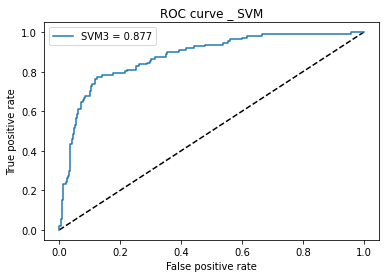

0.8618421052631579
(0.8766472710134682, 0, 0.6723211497762204)


<Figure size 432x288 with 0 Axes>

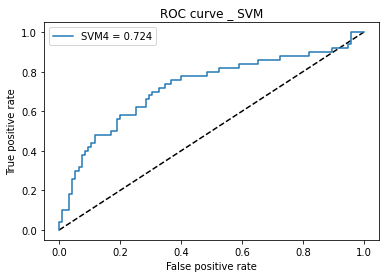

0.7241379310344828
(0.7240000000000001, 0, 0.6644971264367816)


<Figure size 432x288 with 0 Axes>

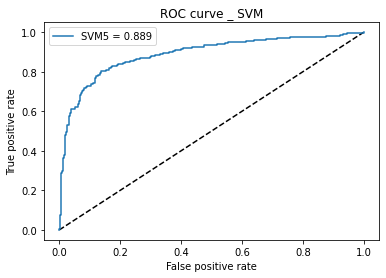

0.8205461638491548
(0.8887517605879318, 0, 0.8295152176101757)


<Figure size 432x288 with 0 Axes>

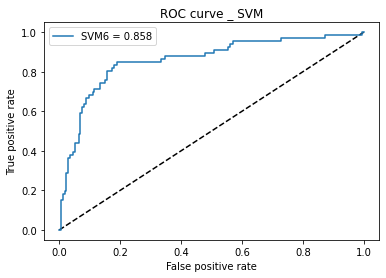

0.8410041841004184
(0.8575056927658085, 0, 0.744564385741705)


<Figure size 432x288 with 0 Axes>

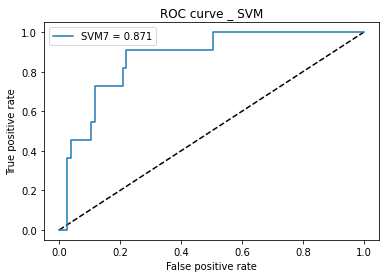

0.8409090909090909
(0.871310507674144, 0, 0.5011363636363636)


<Figure size 432x288 with 0 Axes>

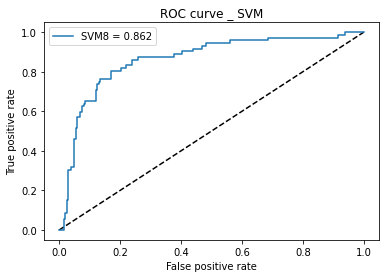

0.8278388278388278
(0.8620784964068546, 0, 0.7180187582584843)


<Figure size 432x288 with 0 Axes>

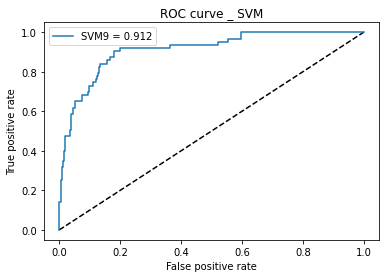

0.8814432989690721
(0.9123809523809524, 0, 0.6786372400446806)


<Figure size 432x288 with 0 Axes>

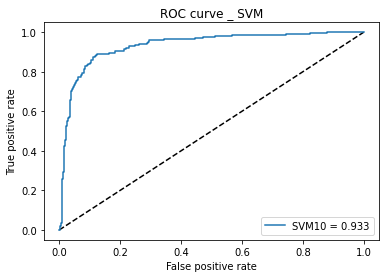

0.8815104166666666
(0.9326665022015893, 0, 0.8605681036459527)


<Figure size 432x288 with 0 Axes>

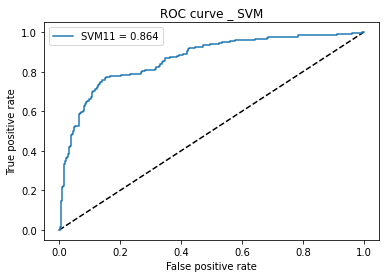

0.7948717948717948
(0.864248216449051, 0, 0.7761082602118254)


<Figure size 432x288 with 0 Axes>

In [34]:

condition = np.where(np.isnan(Y_test))
Y_test[condition] = -1
condition = np.where(np.isnan(Y_train))
Y_train[condition] = -1
for i in range(12):
  Y_test_i = Y_test[:, i]
  Y_train_i = Y_train[:,i]
  i2 = 0
  X_test_i = X_test
  while i2 < len(Y_test_i):
      if Y_test_i[i2] == -1 :
          Y_test_i = np.delete(Y_test_i, i2, axis = 0)
          X_test_i = np.delete(X_test_i, i2, axis=0)
      else:
          i2 = i2 + 1
  i2 = 0
  X_train_i = X_train
  while i2 < len(Y_train_i):
      if Y_train_i[i2] == -1 :
          Y_train_i = np.delete(Y_train_i, i2, axis = 0)
          X_train_i = np.delete(X_train_i, i2, axis = 0)
      else:
          i2 = i2 + 1
  
  from sklearn.svm import SVC
  svm_model_linear = SVC(kernel='linear', C=0.1).fit(X_train_i, Y_train_i)
  score1 = ROC_ML(svm_model_linear, X_test_i, Y_test_i, "SVM", i)
  accuracy = svm_model_linear.score( X_test_i, Y_test_i)
  print(accuracy)
  print(score1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


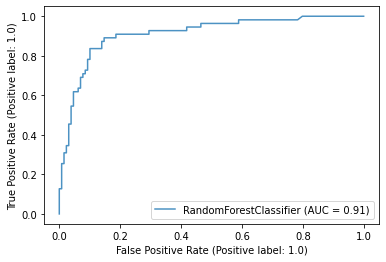

0.8532608695652174
(0.91092318534179, 0, 0.7874505928853756)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


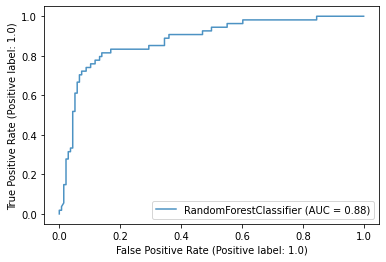

0.8526315789473684
(0.8798338779956427, 0.6296296296296297, 0.772208298524088)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


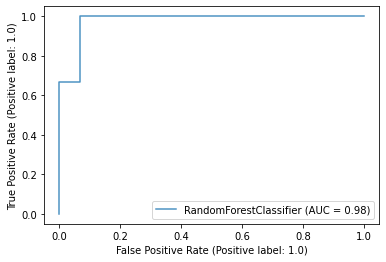

0.9361702127659575
(0.9772727272727272, 0, 0.5319148936170213)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


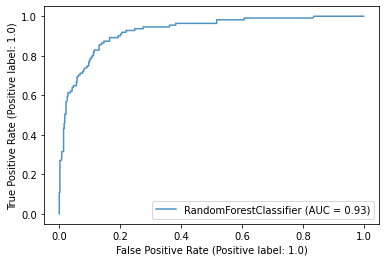

0.8930921052631579
(0.9268584479852084, 0, 0.7330349637915428)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


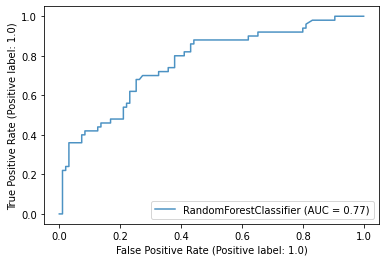

0.7379310344827587
(0.7657894736842105, 0, 0.6605911330049261)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


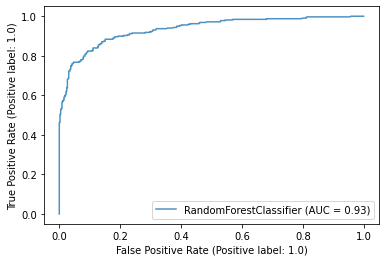

0.8660598179453837
(0.9344852110613731, 0, 0.8781389105124905)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


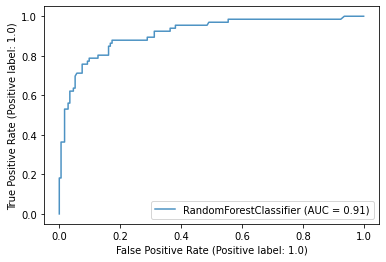

0.8744769874476988
(0.9125941495883692, 0, 0.8009819738286048)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


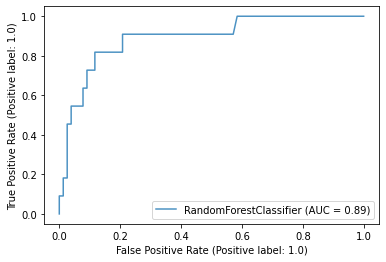

0.9090909090909091
(0.8907910271546635, 0, 0.6344696969696969)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


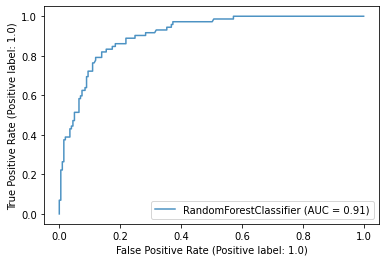

0.8388278388278388
(0.908409342177999, 0, 0.724853775257001)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


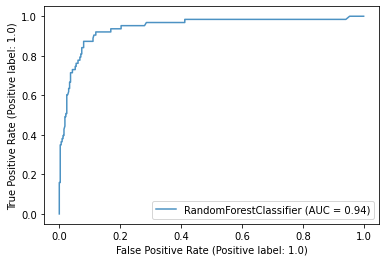

0.9201030927835051
(0.9429792429792428, 0, 0.7682697679142756)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


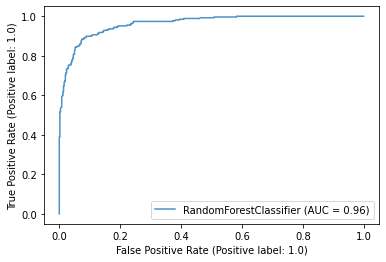

0.91015625
(0.9632158903167448, 0.8389513108614233, 0.8954704470973782)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


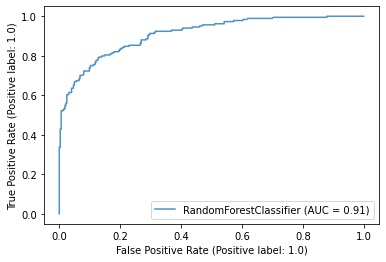

0.8461538461538461
(0.9105279983847087, 0, 0.8276992224433062)


In [35]:

condition = np.where(np.isnan(Y_test))
Y_test[condition] = -1
condition = np.where(np.isnan(Y_train))
Y_train[condition] = -1
for i in range(12):
  Y_test_i = Y_test[:, i]
  Y_train_i = Y_train[:,i]
  i2 = 0
  X_test_i = X_test
  while i2 < len(Y_test_i):
      if Y_test_i[i2] == -1 :
          Y_test_i = np.delete(Y_test_i, i2, axis = 0)
          X_test_i = np.delete(X_test_i, i2, axis=0)
      else:
          i2 = i2 + 1
  i2 = 0
  X_train_i = X_train
  while i2 < len(Y_train_i):
      if Y_train_i[i2] == -1 :
          Y_train_i = np.delete(Y_train_i, i2, axis = 0)
          X_train_i = np.delete(X_train_i, i2, axis = 0)
      else:
          i2 = i2 + 1
  
  from sklearn.ensemble import RandomForestClassifier
  rf_model_linear = RandomForestClassifier(n_estimators=140, min_samples_split=4,
                                    bootstrap=False, max_depth=50).fit(X_train_i, Y_train_i)
  score1 = ROC_ML(rf_model_linear,X_test_i, Y_test_i, "LR", i, rf=True)

  accuracy = rf_model_linear.score(X_test_i, Y_test_i)
  print(accuracy)
  print(score1)
